\begin{equation}
\int_{S} K(x, y) y_2 dy
\end{equation}

Ideas:
* there could be a bug in adaptive.hpp
* maybe recursive subdivision is better than gauss-kronrod for this type of problem.
* ~~kahan summation might be necessary. perhaps the adding and subtracting of the error causes problems?~~
* align the python numpy kernels with the nearfield.cpp kernels.

In [1]:
from tectosaur2.nb_config import setup
setup()

import numpy as np
from tectosaur2 import gauss_rule, integrate_term
from tectosaur2.mesh import unit_circle
from tectosaur2.laplace2d import hypersingular
from tectosaur2.global_qbx import global_qbx_self
quad_rule = gauss_rule(10)
circle = unit_circle(quad_rule)
circle.n_panels

gmats = []
gvecs = []
v = np.cos(circle.pts[:,1])
ps = np.arange(3, 8)
for p in ps:
    gmat, report = global_qbx_self(hypersingular, circle, p, 1.0, 10, return_report=True)
    gmats.append(gmat)
    gvecs.append(gmat[:,:,:,0].dot(v))
lmat, lreport = integrate_term(hypersingular, circle.pts, circle, safety_mode=True, return_report=True)
lvec = lmat[:,:,:,0].dot(v)

print(np.max(np.abs(lvec - gvecs[-1])))

2.4279452615072472e-09


/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:206: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(
/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:214: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(


In [2]:
lmat, lreport = integrate_term(hypersingular, circle.pts, circle, return_report=True)
lvec = lmat[:,:,:,0].dot(v)
print(np.max(np.abs(lvec - gvecs[-1])))

1.20824183991175e-11


In [3]:
for i in range(1, ps.shape[0]):
    print('\n', i)
    print(np.max(np.abs(gmats[i] - gmat[i - 1])))
    print(np.max(np.abs(gvecs[i] - gvecs[i - 1])))


 1
4.657536261689784
8.12064950692637e-05

 2
5.704405858601769
7.705862049567358e-07

 3
8.12835335669428
3.9674554669355544e-08

 4
9.690547112513867
2.4950611021701263e-10


# Analytic comparison 

Let's use the analytic solution for stress for slip on a line segment in a fullspace extending from y = -1 to y = 1. From page 35 of the Segall book. 

In [4]:
import sympy as sp
import matplotlib.pyplot as plt
from tectosaur2 import panelize_symbolic_surface, pts_grid
t = sp.var('t')
fault = panelize_symbolic_surface(t, 0*t, t, quad_rule, n_panels=1)

In [5]:
def analytical_stress(obsx, obsy):
    rp = obsx ** 2 + (obsy + 1) ** 2
    ri = obsx ** 2 + (obsy - 1) ** 2
    sxz = -(1.0 / (2 * np.pi)) * (((obsy + 1) / rp) - ((obsy - 1) / ri))
    syz = (1.0 / (2 * np.pi)) * ((obsx / rp) - (obsx / ri))
    return sxz, syz

In [6]:
def run(zoomx, zoomy):
    nobs = 200
    xs = np.linspace(*zoomx, nobs)
    ys = np.linspace(*zoomy, nobs)
    obs_pts = pts_grid(xs, ys)
    obsx = obs_pts[:, 0]
    obsy = obs_pts[:, 1]

    sing = np.array([(0,-1), (0, 1)])
    stress_mat, report = integrate_term(hypersingular, obs_pts, fault, singularities=sing, return_report=True)
    interior_stress = stress_mat[:,:,:,0].sum(axis=2)
    analytical_sxz, analytical_syz = analytical_stress(obsx, obsy)
    interior_sxz = interior_stress[:,0]
    interior_syz = interior_stress[:,1]
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sxz_err = np.log10(np.abs(interior_sxz - analytical_sxz))
        syz_err = np.log10(np.abs(interior_syz - analytical_syz))
    plt.figure(figsize=(12, 8))

    plots = [
        ("analytical_sxz", "$\sigma_{xz}$"),
        ("analytical_syz", "$\sigma_{yz}$"),
        ("sxz_err", r"$\log_{10}|\sigma_{xz,\textrm{BIE}} - \sigma_{xz,\textrm{analytic}}|$"),
        ("syz_err", r"$\log_{10}|\sigma_{yz,\textrm{BIE}} - \sigma_{yz,\textrm{analytic}}|$")
    ]
    for i, (k, title) in enumerate(plots):
        plt.subplot(2, 2, 1 + i)
        plt.title(title)
        v = locals()[k].reshape((nobs, nobs))
        v2d = v.reshape((nobs, nobs))
        if i < 2:
            levels = np.linspace(-0.5, 0.5, 11)
        else:
            levels = np.linspace(-14, -1, 14)
        cntf = plt.contourf(xs, ys, v2d, levels=levels, extend="both")
        plt.contour(
            xs,
            ys,
            v2d,
            colors="k",
            linestyles="-",
            linewidths=0.5,
            levels=levels,
            extend="both",
        )
        plt.colorbar(cntf)
        # plt.xlim([-0.01, 0.01])
        # plt.ylim([-0.02, 0.0])

    plt.tight_layout()
    plt.show()


In [7]:

# run([-2, 2], [-2, 2])
# run([-0.5, 0.5], [0.5, 1.5])
# run([-0.1, 0.1], [0.9, 1.1])
# run([-0.003, 0.003], [0.997, 1.003])

In [8]:
xs = np.linspace(-0.003, 0.003, 100)
ys = [1.001] * xs.shape[0] 
obs_pts = np.array([xs, ys]).T.copy()
sing = np.array([(0,-1), (0, 1)])
stress_mat, report = integrate_term(hypersingular, obs_pts, fault, safety_mode=True, singularities=sing, return_report=True)
interior_stress = stress_mat[:,:,:,0].sum(axis=2)
analytical_sxz, analytical_syz = analytical_stress(obs_pts[:,0], obs_pts[:,1])
interior_sxz = interior_stress[:,0]
interior_syz = interior_stress[:,1]
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sxz_err = np.log10(np.abs(interior_sxz - analytical_sxz))
    syz_err = np.log10(np.abs(interior_syz - analytical_syz))

/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:206: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(


In [9]:
report.keys()

dict_keys(['combined_src', 'srcs', 'obs_pts', 'n_qbx', 'p', 'qbx_integration_error', 'qbx_n_subsets', 'qbx_integration_failed', 'max_order_reached', 'use_qbx', 'exp_centers', 'exp_rs', 'closest_src_pts', 'direction', 'on_surface', 'n_nearfield', 'use_nearfield'])

In [10]:
report['p']

array([34, 34, 34, 34, 34, 34, 34, 34, 34, 24, 24, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 24, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 24, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 24, 24, 34, 34, 34, 34, 34, 34, 34, 34, 34],
      dtype=int32)

In [11]:
report['qbx_integration_error']

array([4.42992865e-13, 4.62657690e-13, 4.74356665e-13, 4.83071916e-13,
       4.94757013e-13, 5.08926234e-13, 5.21124810e-13, 5.28022071e-13,
       5.33309508e-13, 5.36452827e-13, 5.45695433e-13, 5.51329815e-13,
       5.67934588e-13, 5.93664007e-13, 6.15405296e-13, 6.34024083e-13,
       6.53439108e-13, 6.73388970e-13, 6.86210637e-13, 7.07765443e-13,
       7.26751992e-13, 7.66046948e-13, 9.75052622e-13, 8.63399630e-13,
       9.24128829e-13, 9.72735781e-13, 9.49205124e-13, 9.94989681e-13,
       9.94147483e-13, 1.08099566e-12, 1.17735332e-12, 1.27199829e-12,
       1.36167079e-12, 1.42266322e-12, 1.53093627e-12, 1.63462814e-12,
       1.70608951e-12, 1.80493301e-12, 1.86095956e-12, 1.93173007e-12,
       1.94139415e-12, 1.93069276e-12, 1.87398857e-12, 1.80369131e-12,
       2.05214317e-12, 2.32521044e-12, 2.55602714e-12, 2.73765343e-12,
       2.88514395e-12, 2.95122775e-12, 2.95122775e-12, 2.88726610e-12,
       2.75579528e-12, 2.55602714e-12, 2.32417375e-12, 2.04771507e-12,
      

In [12]:
report['exp_centers'][:, 1]

array([1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001,
       1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001,
       1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001,
       1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001,
       1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001,
       1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001,
       1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001,
       1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001,
       1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001,
       1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001,
       1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001,
       1.001])

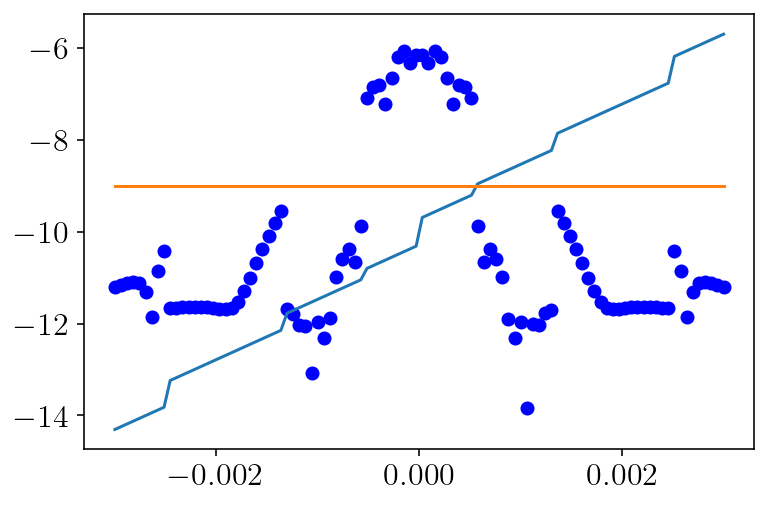

In [13]:
plt.plot(xs, sxz_err, 'bo')
plt.plot(xs, report['exp_centers'][:, 0] * 1000 - 10)
plt.plot(xs, (report['exp_centers'][:, 1] - 1) * 1000 - 10)
plt.show()

In [14]:
from tectosaur2.laplace2d import Hypersingular
ys = np.linspace(1.0, 1.00005, 2)
xs = [0.0] * ys.shape[0] 
obs_pts = np.array([xs, ys]).T.copy()
sing = np.array([(0,-1), (0, 1)])
stress_mat, report = integrate_term(Hypersingular(d_qbx=0), obs_pts, fault, safety_mode=True, singularities=sing, return_report=True)
interior_stress = stress_mat[:,:,:,0].sum(axis=2)
analytical_sxz, analytical_syz = analytical_stress(obs_pts[:,0], obs_pts[:,1])
interior_sxz = interior_stress[:,0]
interior_syz = interior_stress[:,1]
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sxz_err = np.log10(np.abs(interior_sxz - analytical_sxz))
    syz_err = np.log10(np.abs(interior_syz - analytical_syz))

/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:287: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(
/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_73562/2211585198.py:4: RuntimeWarning: invalid value encountered in true_divide
  sxz = -(1.0 / (2 * np.pi)) * (((obsy + 1) / rp) - ((obsy - 1) / ri))
/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_73562/2211585198.py:5: RuntimeWarning: invalid value encountered in true_divide
  syz = (1.0 / (2 * np.pi)) * ((obsx / rp) - (obsx / ri))


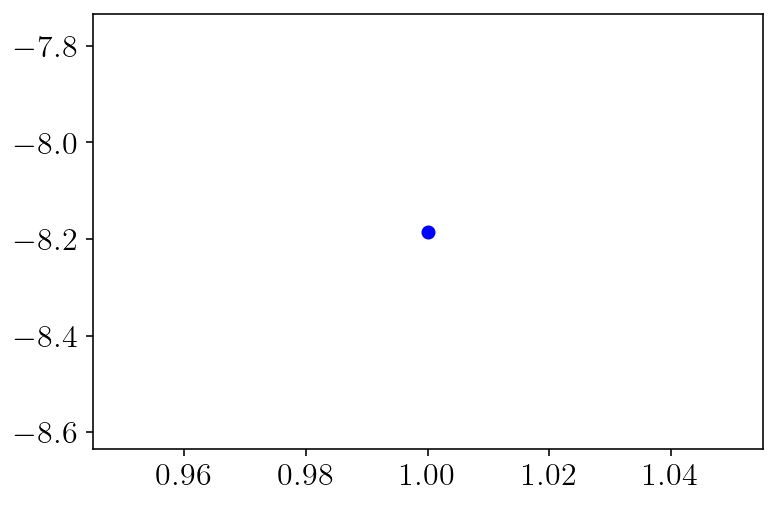

In [15]:
plt.plot(ys, sxz_err, 'bo')
plt.show()
# plt.plot(ys, report['exp_rs'])
# plt.show()

In [16]:
correct = analytical_sxz[1]
tct_val = interior_sxz[1]

In [17]:
report['nearfield_n_subsets']

array([2000, 2000], dtype=int32)

In [18]:
report['nearfield_integration_error']

array([5.29653494e-02, 1.32851727e-09])

In [19]:
interior_sxz[1]

3183.019286342501

In [20]:
from tectosaur2.laplace2d import Hypersingular
op = obs_pts[1:]
# op = report['exp_centers'][50:51]
kernel = Hypersingular()
def integrand(srcy):
    src_normals = np.zeros((srcy.shape[0], 2))
    src_normals[:,0] = -1
    entry = kernel.kernel(op, np.array([0*srcy, srcy]).T.copy(), src_normals)
    return entry[0,0,:,0]

grule = gauss_rule(8)
def simple_quad(domain):
    xs = domain[0] + (domain[1] - domain[0]) * ((grule[0] + 1) * 0.5)
    ws = (domain[1] - domain[0]) * 0.5 * grule[1]
    return np.sum(integrand(xs) * ws)

def recursive_quad(domain, tol, base_value=None):
    if base_value is None:
        base_value = simple_quad(domain)
    center = (domain[0] + domain[1]) * 0.5
    ldom = [domain[0], center]
    lval = simple_quad(ldom)

    rdom = [center, domain[1]]
    rval = simple_quad(rdom)
    better_value = lval + rval
    err = np.abs(better_value - base_value)
    if err < tol:
        return better_value, 2, err
    else:
        left = recursive_quad(ldom, tol, lval)
        right = recursive_quad(rdom, tol, rval)
        return left[0] + right[0], left[1] + right[1], left[2] + right[2]

val, n_integrals, err = recursive_quad([-1, 1], 1e-12)
val, val - correct, val - tct_val, n_integrals, err

(3183.019286349031,
 4.547473508864641e-13,
 6.530171958729625e-09,
 162,
 2.3476803834299176e-11)

In [21]:
import quadpy
kronrod_n = 10
kronrod_rule = quadpy.c1.gauss_kronrod(kronrod_n)
kronrod_qx = kronrod_rule.points
kronrod_qw = kronrod_rule.weights
gauss_r = quadpy.c1.gauss_legendre(kronrod_n)
gauss_qx = gauss_r.points
kronrod_qw_gauss = gauss_r.weights

import heapq
def gk_quad(domain):
    gxs = domain[0] + (domain[1] - domain[0]) * ((gauss_qx + 1) * 0.5)
    gws = (domain[1] - domain[0]) * 0.5 * kronrod_qw_gauss
    kxs = domain[0] + (domain[1] - domain[0]) * ((kronrod_qx + 1) * 0.5)
    kws = (domain[1] - domain[0]) * 0.5 * kronrod_qw
    est1 = np.sum(integrand(gxs) * gws)
    est2 = np.sum(integrand(kxs) * kws)
    return est1, est2, np.abs(est2 - est1)

def priority_quad(tol):
    low_est, est, err = gk_quad([-1, 1])

    queue = []
    heapq.heappush(queue, (-err, est, -1, 1))

    for i in range(1000):
        cur_integral = heapq.heappop(queue)
        midpt = (cur_integral[2] + cur_integral[3]) * 0.5
        left = gk_quad([cur_integral[2], midpt])
        right = gk_quad([midpt, cur_integral[3]])
        err += cur_integral[0] + left[2] + right[2]
        est += -cur_integral[1] + left[1] + right[1]
        heapq.heappush(queue, (-left[2], left[1], cur_integral[2], midpt))
        heapq.heappush(queue, (-right[2], right[1], midpt, cur_integral[3]))
        if err < tol:
            break
    return est, i, err

val, n_integrals, err = priority_quad(1e-12)
val, val - correct, val - tct_val, n_integrals, err

(3183.01928634904,
 9.549694368615746e-12,
 6.539266905747354e-09,
 208,
 9.883760476725456e-13)

In [22]:
def kahan_update(kv, a):
    y = a - kv[1]
    t = kv[0] + y
    kv[1] = (t - kv[0]) - y
    kv[0] = t


def exact_quad(domain):
    rp = op[:, 0] ** 2 + (op[:, 1] - domain[0]) ** 2
    ri = op[:, 0] ** 2 + (op[:, 1] - domain[1]) ** 2
    sxz = -(1.0 / (2 * np.pi)) * (
        ((op[:, 1] - domain[0]) / rp) - ((op[:, 1] - domain[1]) / ri)
    )
    return sxz, sxz, 0


def kahan_priority_quad(tol, exact=False, kahan=False):
    quad_fnc = exact_quad if exact else gk_quad
    low_est, est_, err_ = quad_fnc([-1, 1])
    est = [est_, 0]
    err = [err_, 0]

    queue = []
    heapq.heappush(queue, (-err[0], est[0], -1, 1))

    for i in range(1000):

        cur_integral = heapq.heappop(queue)
        midpt = (cur_integral[2] + cur_integral[3]) * 0.5
        left = quad_fnc([cur_integral[2], midpt])
        right = quad_fnc([midpt, cur_integral[3]])

        if kahan:
            kahan_update(err, cur_integral[0])
            kahan_update(err, left[2])
            kahan_update(err, right[2])

            kahan_update(est, -cur_integral[1])
            kahan_update(est, left[1])
            kahan_update(est, right[1])
        else:
            err[0] += cur_integral[0] + left[2] + right[2]
            est[0] += -cur_integral[1] + left[1] + right[1]

        heapq.heappush(queue, (-left[2], left[1], cur_integral[2], midpt))
        heapq.heappush(queue, (-right[2], right[1], midpt, cur_integral[3]))

        if err[0] < tol:
            break
    return est[0] + est[1], i, err[0] + err[1]



In [23]:

val, n_integrals, err = kahan_priority_quad(1e-13, exact=True, kahan=False)
val, val - correct, val - tct_val, n_integrals, err


(array([3183.01928635]), array([0.]), array([6.52971721e-09]), 0, 0)